Ground state energies of the H$_2$ and He$_2$ molecules using a variational quantum eigensolver

#### Note for the grader
In case you are going to run the notebook, make sure to have installed qiskit==1.0.0 and pydantic==2.7.1. (Reason: the newest version of qiskit doesn't work with simulating noisy circuits on the qiskit.aer backend in the newest version Pennylane.)

In [1]:
# Installs for jupyter.cs.aalto.fi running. Restart kernel after running this cell if something doesn't run.

!pip install --quiet optax
!pip install --quiet pennylane
!pip install --quiet pennylane-qiskit
!pip install --quiet openfermion
!pip install --quiet qiskit==1.0.0
!pip install --quiet pydantic==2.7.1
#!pip install --quiet pyscf

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.4.1 requires pybind11, which is not installed.
eo-learn-coregistration 1.4.2 requires opencv-python-headless, which is not installed.
eo-learn-mask 1.4.2 requires opencv-python-headless, which is not installed.
imgaug 0.4.0 requires opencv-python-headless, which is not installed.
spectrum 0.8.1 requires easydev, which is not installed.
eo-learn-core 1.4.2 requires sentinelhub>=3.9.0, but you have sentinelhub 3.4.4 which is incompatible.
fusets 2.0.1 requires numpy==1.23.5, but you have numpy 1.26.4 which is incompatible.
pystan 3.7.0 requires httpstan<4.11,>=4.10, but you have httpstan 4.6.1 which is incompatible.
sentinelhub 3.4.4 requires pillow<=8.4.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are

## 1 Introduction

Chemistry has been widely considered as one of the most promising fields where quantum computers could provide computational advantage due to their native capability for simulating quantum mechanical systems among many tasks. One of these tasks includes finding the ground state energy of a given molecule. It is an important subprocess in chemistry, crucial for understanding various molecular properties such as dissociation energy and reactivity [1]. The ground state energy provides insights into the stability and behavior of molecules under different conditions.

Multiple algorithms exist for approximately calculating this lowest energy value. The Variational Quantum Eigensolver (VQE) is one such algorithm that can be executed on a gate-based quantum computer [2]. Quantum Phase Estimation (QPE) [3] is another algorithm known for providing a polynomial speedup in calculating eigenvalues of a given Hamiltonian. However, QPE requires a large number of logical qubits, deep circuits, and coherent evolution, making it challenging to implement during the ongoing noisy intermediate-scale quantum (NISQ) era [4]. In contrast, the VQE is more suitable for NISQ devices due to its lower hardware requirements and shorter circuit depth. Indeed, VQEs have been taunted as one of the primary, practical applications for the NISQ era. However, the usage of the algorithm does not come without a cost: the VQE is a heuristic algorithm whereas the QPE is not. This also means that computational complexity statements about its efficiency are difficult to pose.

The research question I pose here is: how well does the VQE algorithm match the ground truth with and without noise for the H$_2$ and He$_2$ molecules and how much does the restriction of the active electron count affect this? 

### VQE

The variational quantum eigensolver aims at finding the ground state energy by minimizing the following equation

$$min_\theta \langle\Psi(\theta)|\hat H|\Psi(\theta)\rangle.$$

Here, $|\Psi(\theta)\rangle$ represents a variational ansatz. In the circuit, it is realized as a parametrized unitary $U(\theta)$ which becomes the target of optimization. There are multiple ansatze to choose from and there is no exact way of saying which one should perform the best with a given molecule [5]. 

The Ritz variational principle [6] stands as

$$E_0\leq\frac{\langle\Psi|\hat H|\Psi\rangle}{\langle\Psi|\Psi\rangle}$$

meaning that the optimization of this ansatz cannot reach below the de-facto ground state energy.

However, one cannot simply throw the Hamiltonian of a given molecule at a quantum computer and hope for it to figure the ground state. The mapping of a given moleular Hamiltonian onto the VQE quantum circuit happens as follows. For an examplary case, let us begin with the 1st quantized version of the H$_2$ molecule.

$$\hat H = \hat T + \hat V$$<br>

whose kinetic operator stands as

$$\hat T = \hat T_{nucl} + \hat T_{elec}$$
$$= -\frac{\hbar^2}{2}\sum_{i\in I_n}\frac{1}{m_i}\nabla_i^2 - \frac{\hbar^2}{2m_e}\sum_{i\in I_e}\nabla_i^2$$<br>

where $m_i$ is the mass of the nucleus and $I_n$ & $I_e$ the indices for the nuclei and electrons, respectively. The potential energy operator is

$$\hat V = \hat V_{elec-elec} + \hat V_{elec-nucl} + \hat V_{nucl-nucl}$$
$$=\sum_{i,j\in I_e} \frac{e^2}{4\pi\varepsilon_0|\vec r_i-\vec r_j|} - \sum_{i\in I_e, j\in I_n}\frac{Z_je^2}{4\pi\varepsilon_0|\vec r_i-\vec r_j|} + \sum_{i,j\in I_n}\frac{Z_i Z_je^2}{4\pi\varepsilon_0|\vec r_i-\vec r_j|}$$<br>

where $\vec r_i$ & $\vec r_j$ represent positions of the particels, and $Z_i$ & $Z_j$ the proton numbers of nuclei $i$ and $j$, respectively.

The total Hamiltonian has a lot of terms, and it is desirable to make some valid assumptions to simplify it. Compared to the electrons, the nuclei stay roughly at their same respective positions as $t$ evolves. More precisely, the electrons move at speeds many thousands of times faster than the nuclei. This difference is big enough to the extent that the nuclei can be taken as stationary points in space. This assumption is called the Born-Oppenheimer approximation [1] and in our case, it implies that we ignore $\hat T_{kin}$ due to its negligibility and $\hat V_{nucl-nucl}$ as well since it becomes a constant which we then ignore in the Hamiltonian for the meantime. The remaining terms yield us the so-called molecular Hamiltonian

$$\hat H_{molecular} = \hat T_{elec} + \hat V_{elec-elec} + \hat V_{elec-nucl}$$
$$= - \frac{\hbar^2}{2m_e}\sum_{i\in I_e}\nabla_i^2 + \sum_{i,j\in I_e} \frac{e^2}{4\pi\varepsilon_0|\vec r_i-\vec r_j|} - \sum_{i\in I_e, j\in I_n}\frac{Z_je^2}{4\pi\varepsilon_0|\vec r_i-\vec r_j|}.$$

Using the relations

$$\sum_i h(x_i)=\sum_{pq}\langle p|\hat h|q\rangle \hat a_p^{\dagger}\hat a_q$$

$$\sum_{ij} h(x_i, x_j)=\sum_{pqrs}\langle pq|\hat h|rs\rangle \hat a_p^{\dagger}\hat a_q^{\dagger}\hat a_s\hat a_r$$

for mapping between first and second quantization where $\langle p|\hat h|q\rangle$ and $\langle pq|\hat h|rs\rangle$ become integrals through the whole space determining the constants $\beta$, we obtain the second quantized Hamiltonian

$$\hat H=\beta_{pq}\hat a^\dagger_p \hat a_q + \beta_{pqrs}\hat a^\dagger_p \hat a^\dagger_q \hat a_r \hat a_s + const.$$

where we have brought back the constant.

With, for example, the Jordan-Wigner transform [7], this second quantized Hamiltonian can now be expressed in terms of Pauli strings - tensor products of regular single-qubit unitary operations. A generic annihilation operator acting on the $s$:th state takes the form of

$$\frac{1}{2}(X_s+iY_s)\Pi_{i=1}^s Z_i$$

from which the creation operator mapping follows as well.

Quantum computers are currently noisy and require multiple qubits for creating an ideal, so-called logical qubit [8]. Having a great number of ideal qubits is somewhere off in the future, but in the meantime, during the NISQ era, we are interested in noisy simulations as well. This is why in this project, we will consider noise-free and noisy quantum circuits simulated on classical hardware.

I have two hypotheses for the results of this project. First, the noise-free VQE should match the ground truth plot very well and the noisy model should naturally perform worse than the former. Second, the smaller the active electron count compared to the potential maximum, the less accurate the result of the VQE should be because of the restricted solution space.

## Computational efficiency

Since the VQE is a heuristic algorithm, computational complexity statements are not trivial to come up with. First, simple classical matrix multiplication ($O(n^3)$) of an $n$-qubit system requires the the multiplication of with a matrix with $2^n\times 2^n$ elements. On a quantum computer, one such operation happens in $O(1)$ time. However, for the actual results, one needs to perform multiple measurements of the circuit end state $O(1/\epsilon^2)$ to achieve an error of $\epsilon$. Performance advantages are generally expected to take place with qubit counts in the order of 1000.

For simulating a quantum circuit on a classical computer, the memory cost scales exponentially with the qubit number whereas on a quantum computer the relationship linear. However, since the circuits in this project are small, even a laptop can simulate them almost instantly aside from the noisy models.

## 2 Method

For each molecule reviewed in this project, Xanadu's Pennylane library was used for obtaining the molecular Hamiltonian and the number of qubits required for the circuit. The function doing this, ```qchem.molecular_hamiltonian```, was given the inputs of the atoms involved as strings and their respective geometry in three dimensions. In addition to these, ```molecular_hamiltonian``` takes as optional inputs the number of active orbitals. The selection process for this, especially with larger molecules, requires a lot of domain expertise in computational chemistry and is an important part of the performance of electron structure problem algorithms. This is simply caused by a larger solution space allowing for greater assurance of including the global minimum but greater computational resource requirements. By default, ```molecular_hamiltonian``` assumes all orbitals are active. This default value was used for all of the runs in this project.

The circuits for H$_2$ and He$_2$ consisted of the Hartree-Fock state initialization and the particle number conserving, parametrized double excitation unitary as the ansatz. They returned $\langle \hat H\rangle$ as the optimized quantity and $Var(\langle \hat H\rangle)$ in addition for noisy simulations.

The circuits were run with Xanadu's quantum machine learning library Pennylane and optimized with Jax and Optax using stochastic gradient descent with a learning rate of $0.4$. For noise-free simulations, the 'lightning.qubit' backend was used and 'qiskit.aer' for noisy ones

Below is the class ```VQEs``` that takes care of some subroutines when training a VQE. It is useful for centrally storing and retrieving data related to the optimization process for a given molecule with a given simulator device, and especially useful for dissociation profile plots. This class would make testing with many configurations very scalable. Additionally, the training function ```train_VQE``` is presented.

In [2]:
class VQEs:
    def __init__(self, symbols, electrons, Rs, qubits=None, dev=None, backend='lightning.qubit', noise_model=None, shots=None):
        '''Store and return training related data for a given (molecule, pennylane.dev) pair.
           Makes large-scale testing more accessible.
        Attributes:
            symbols (list[str]):            a list containing the single atoms that form the molecule.
            electrons (int):                integer value representing the total number of active electrons in the molecule.                 
            Rs (list[float]):               a list of the intermolecular distances for which the optimization has been run.
            qubits (int):                   integer representing the number of qubits used in the circuit. In the case of 
                                            == None, _check_and_create_qubits will compute the needed value.
            dev (pennylane.dev):            the simulator that the VQE was run with.
            energies (list[list[float]]):   a list containing all of the training energy histories for all values of Rs.           
            variances (list[list[float]]):  a list containing all of the training energy variance histories for all values of Rs.    # Lists since the number of iterations is not predictable
            iterations (int):               the number of training steps
        '''
        self.symbols = symbols
        self.qubits = self._check_and_create_qubits(symbols, qubits)
        self.electrons = electrons
        self.Rs = Rs
        self.backend = backend
        self.noise_model = noise_model
        self.shots = shots
        self.dev = self._check_and_create_dev(symbols=symbols, qubits=self.qubits, backend=self.backend, 
                                              noise_model=self.noise_model, shots=self.shots)
        self.energies = []
        self.variances = []
        self.thetas = []

    def return_last_energies(self):
        '''
        Returns:
            list[float]: the last energy expectation value for each value of Rs
        '''
        res = []
        for l in self.energies:
            res.append(l[-1])
        return res
    def return_last_vars(self):
        '''
        Returns:
            list[float]: the last variance value for each value of Rs
        '''
        res = []
        for l in self.variances:
            res.append(l[-1])
        return res
    def Hamiltonian(self, geometry):
        '''Generates and returns the molecular Hamiltonian for the given geometry of the atoms.
        Args:
            geometry (list[float]): A list of atomic coordinates representing the geometry of the molecule.
        
        Returns:
            qml.Hamiltonian: The Hamiltonian of the molecule for the given geometry.
        '''
        H, _ = qml.qchem.molecular_hamiltonian(self.symbols, geometry)
        return H

    def add_energies(self, energies):
        '''Adds a new set of energy training results to the energies list.
        Args:
            energies (list[float]): A list of energy values obtained from a training iteration.
        '''
        self.energies.append(energies)

    def add_variances(self, variances):
        '''Adds a new set of variance training results to the variances list.
        Args:
            variances (list[float]): A list of variance values obtained from a training iteration.
        '''
        self.variances.append(variances)

    def add_thetas(self, thetas):
        '''Adds a new set of parameter values (thetas) to the thetas list.
        Args:
            thetas (list[float]): A list of parameter values obtained from a training iteration.
        '''
        self.thetas.append(thetas)

    def _check_and_create_qubits(self, symbols, qubits, charge=0, mult=1):
        '''Private method to determine the number of qubits needed for the given molecule.
        Args:
            symbols (list[str]):  A list of atomic symbols representing the molecule.
            qubits (int or None): The number of qubits specified. If None, this method calculates the required number.
            charge (int):         The total charge of the molecule.
            mult (int):           The multiplicity of the molecule.
        Returns:
            int: The number of qubits required for the molecule.
        '''
        if qubits is None:
            temp_coord = [0., 0., 0.]  # Mock coordinates for each atom, won't affect the number of qubits needed
            geometry = []
            for _ in range(len(symbols)):
                geometry.append(temp_coord)
            _, qubits_new = qml.qchem.molecular_hamiltonian(symbols, np.array(geometry), charge=charge, mult=mult)
            return qubits_new
        else:
            return qubits

    def _check_and_create_dev(self, symbols, qubits, dev=None, backend='lightning.qubit', noise_model=None, shots=None):
        '''Private method for creating the device (self.dev) based on the information provided during the instantiation of the class.
        Args:
            symbols (list[str]):         A list of atomic symbols representing the molecule.
            qubits (int):                The number of qubits to be used in the simulation.
            dev (pennylane.dev or None): An optional device to be used. If None, a new device is created.
            backend (str):               The backend to be used for the simulation.
            noise_model (qiskit.providers.aer.noise.NoiseModel or None): An optional noise model for the simulation.
            shots (int or None):         The number of shots to be used for the simulation.
        Returns:
            pennylane.dev: The created or provided device for running the VQE.
        '''
        if dev is not None:
            return dev  # Trusting that dev is actually a valid device since there are countless types for this and super() doesn't help
        
        temp_coord = [0., 0., 1.]  # Mock coordinates for each atom, won't affect the number of qubits needed
        geometry = []
        for _ in range(len(symbols)):
            geometry.append(temp_coord)
        
        geometry = np.array(geometry, requires_grad=False)
        _, qubits = qml.qchem.molecular_hamiltonian(symbols, geometry)
        
        if backend == 'lightning.qubit':
            return qml.device("lightning.qubit", wires=qubits)
        elif backend == 'qiskit.aer':
            return qml.device("qiskit.aer", wires=qubits, noise_model=noise_model, shots=shots)
        else:
            raise Exception("Backend not supported!")


In [3]:
import jax
import optax
import pennylane as qml
from pennylane import numpy as np

jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

In [4]:
def train_VQE(VQE, H, iterations_max, tol=1e-06, lr=0.4, print_progress=0):
    '''
    Train the Variational Quantum Eigensolver (VQE) to find the ground state energy of a given molecular Hamiltonian.
    Stores the energy, variance and parameter values to the VQE object for each iteration.
    
    Args:
        VQE (VQEs):            The VQE instance containing the molecule information and device.
        H (qml.Hamiltonian):   The Hamiltonian of the molecule.
        iterations_max (int):  The maximum number of optimization iterations.
        tol (float, optional): The convergence tolerance for the energy. Defaults to 1e-06.
        lr (float, optional):  The learning rate for the stochastic gradient descent optimizer. Defaults to 0.4.
        print_progress (int, optional): Interval for printing progress. If 0, no progress is printed. Defaults to 0.
    
    Returns:
        float: The energy obtained from the last optimization step.
        float: The variance of the result. It is 0 for noise-free simulations.
    '''
    
    # Generate the Hartree-Fock state for the given molecule
    hf = qml.qchem.hf_state(VQE.electrons, VQE.qubits)

    # Define the quantum circuit
    @qml.qnode(VQE.dev)
    def circuit(param, wires):
        qml.BasisState(hf, wires=wires)  # Initialize the circuit in the Hartree-Fock state
        qml.DoubleExcitation(param, wires=[0, 1, 2, 3])  # Apply a double excitation gate
        return qml.expval(H), qml.var(H)  # Return the expected value and variance of the Hamiltonian

    # Define the cost function for optimization
    def cost_fn(param):
        return circuit(param, wires=range(VQE.qubits))

    # Initialize the optimizer with the specified learning rate
    opt = optax.sgd(learning_rate=lr)

    # Initialize the circuit parameter
    theta = np.array(0.)

    # Store the initial values of the cost function
    var, en = cost_fn(theta)
    energy = [en]
    variance = [var]

    # Store the initial value of the circuit parameter
    angle = [theta]

    # Initialize the optimizer state
    opt_state = opt.init(theta)

    # Optimization loop
    for n in range(iterations_max):
        # Compute the gradient of the cost function
        gradient, var = jax.grad(cost_fn, has_aux=True)(theta)
        # Update the parameter using the optimizer
        updates, opt_state = opt.update(gradient, opt_state)
        theta = optax.apply_updates(theta, updates)

        # Evaluate the cost function with the updated parameter
        en, var = cost_fn(theta)
        angle.append(theta)
        energy.append(en)
        variance.append(var)

        # Check for convergence
        conv = np.abs(energy[-1] - energy[-2])

        # Print progress if requested
        if print_progress != 0 and n % print_progress == 0:
            print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

        # Break the loop if convergence criterion is met
        if conv <= tol:
            break

    # Store the results in the VQE instance
    VQE.add_energies(energy)
    VQE.add_variances(variance)
    VQE.add_thetas(angle)
    
    # Return the final energy and variance
    return energy[-1], variance[-1]

Additionally, below is a function for retrieving full configuration interaction (FCI) energies for the different molecules in a streamlined way from the ```openfermion``` library with the ```sto-3g``` basis. The FCI is considered to be among the most if not the most precise methodology for molecular energy calculations [10] hence why we shall use it as our ground truth whenever possible.

In [5]:
from openfermion.chem import MolecularData

def FCI(geometry, Rs, basis='sto-3g', multiplicity=1, charge=0):
    '''Retrieve the Full Configuration Interaction (FCI) energies of a molecule as a function of the bond length.
    Args:
        geometry (list[tuple[str, tuple[float, float, float]]]): The initial geometry of the molecule. Each element is a tuple where the first element is the atomic symbol and the second element is a tuple of the atomic coordinates.
        Rs (list[float]):             A list of bond lengths for which the FCI energies are to be computed.
        basis (str, optional):        The basis set to be used for the FCI calculation. Defaults to 'sto-3g'.
        multiplicity (int, optional): The spin multiplicity of the molecule. Defaults to 1.
        charge (int, optional):       The charge of the molecule. Defaults to 0.
    Returns:
        tuple[np.ndarray, np.ndarray]: Two numpy arrays. The first array contains the unique bond lengths and the second array contains the corresponding FCI energies.
    '''
    fci_energies = []
    unique_R = []

    for i, R in enumerate(Rs):
        rounded = round(float(R), 1)  # Round the bond length to one decimal place
        description = str(rounded)
        
        if rounded not in unique_R:
            unique_R.append(rounded)
            
            # Update the geometry with the current bond length
            updated_geometry = [(atom, (x, y, R)) for atom, (x, y, z) in geometry]
            
            # Create a MolecularData object with the updated geometry
            molecule = MolecularData(
                updated_geometry, basis, multiplicity, charge, description=description
            )

            # Load the molecular data (assuming it has been precomputed and saved)
            molecule.load()

            # Append the FCI energy to the list
            fci_energies.append(molecule.fci_energy)

    return np.array(unique_R), np.array(fci_energies)


### Computations for obtaining the results

The dissociation profiles are calculated for both of the molecules with a noise-free and a noisy simulation. In the noisy simulations, depolarizing errors of $P_{\text{depol-err}}(\text{1-qubit gate})=0.001$ and $P_{\text{depol-err}}(\text{2-qubit gate})=0.001$ as for the $U1$, $U2$ & $U3$ (single qubit) and the $CNOT$ (two-qubit) gates, respectively. Compared to IBM's machine information, these are valid assumptions for runs on an actual quantum computer [11]. Each circuit was evalueated with 1000 shots.

In [6]:
bohr_to_ång = 1.8897259886 # for converting between a.u. and Å

### H$_2$

In [7]:
# noise-free simulation
symbols = ["H", "H"]
active_electrons = 2

H_radii = np.linspace(0.3*bohr_to_ång,3*bohr_to_ång,15)

H, qubits = qml.qchem.molecular_hamiltonian(symbols, np.array([[0.0, 0.0, -1/2], [0.0, 0.0, 1/2]])) # Initialization with arbitrary geometry for qubit count

ideal_H2 = VQEs(symbols=symbols, electrons=active_electrons, Rs=H_radii, qubits=None, backend='lightning.qubit')
for i, R in enumerate(H_radii):
    geometry = np.array([[0.0, 0.0, -R/2], [0.0, 0.0, R/2]], requires_grad=False)
    train_VQE(ideal_H2,ideal_H2.Hamiltonian(geometry), iterations_max=20, tol=1e-06)

/opt/software/lib/python3.10/site-packages/autoray/autoray.py:81: RuntimeWarning: invalid value encountered in sqrt
  return func(*args, **kwargs)
/opt/software/lib/python3.10/site-packages/pennylane/qchem/hartree_fock.py:218: RuntimeWarning: divide by zero encountered in scalar divide
  e = e + (charges[i] * charges[i + j + 1] / qml.math.linalg.norm(r1 - r2))
/opt/software/lib/python3.10/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
I0000 00:00:1718088926.748583     281 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [8]:
# noisy simulation
from qiskit_aer import noise

H, qubits = qml.qchem.molecular_hamiltonian(symbols, np.array([[0.0, 0.0, -1/2], [0.0, 0.0, 1/2]])) # Initialization with arbitrary geometry for qubit count

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate
# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

noisy_H2 = VQEs(symbols=symbols, electrons=active_electrons, Rs=H_radii, qubits=None, backend='qiskit.aer', shots=1000, noise_model=noise_model)
for i, R in enumerate(H_radii):
    geometry = np.array([[0.0, 0.0, -R/2], [0.0, 0.0, R/2]], requires_grad=False)
    train_VQE(noisy_H2,noisy_H2.Hamiltonian(geometry), iterations_max=20, tol=1e-06)

/opt/software/lib/python3.10/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


### He$_2$

In [9]:
symbols = ["He", "He"]
active_electrons = 4

He_radii = np.linspace(0.3*bohr_to_ång,3*bohr_to_ång,15)

H, qubits = qml.qchem.molecular_hamiltonian(symbols, np.array([[0.0, 0.0, -1/2], [0.0, 0.0, 1/2]]))

ideal_He2 = VQEs(symbols=symbols, electrons=active_electrons, Rs=He_radii, qubits=None, backend='lightning.qubit')
for i, R in enumerate(He_radii):
    geometry = np.array([[0.0, 0.0, -R/2], [0.0, 0.0, R/2]], requires_grad=False)
    train_VQE(ideal_He2,ideal_He2.Hamiltonian(geometry), iterations_max=20, tol=1e-06)

/opt/software/lib/python3.10/site-packages/autoray/autoray.py:81: RuntimeWarning: invalid value encountered in sqrt
  return func(*args, **kwargs)
/opt/software/lib/python3.10/site-packages/pennylane/qchem/hartree_fock.py:218: RuntimeWarning: divide by zero encountered in scalar divide
  e = e + (charges[i] * charges[i + j + 1] / qml.math.linalg.norm(r1 - r2))


In [10]:
# noisy, 4 active electrons
noisy_He2 = VQEs(symbols=symbols, electrons=active_electrons, Rs=He_radii, qubits=None, backend='qiskit.aer', shots=1000, noise_model=noise_model)
for i, R in enumerate(He_radii):
    geometry = np.array([[0.0, 0.0, -R/2], [0.0, 0.0, R/2]], requires_grad=False)
    train_VQE(noisy_He2,noisy_He2.Hamiltonian(geometry), iterations_max=20, tol=1e-06)

In [11]:
ideal_He2_2e = VQEs(symbols=symbols, electrons=2, Rs=He_radii, qubits=None, backend='lightning.qubit')
for i, R in enumerate(He_radii):
    geometry = np.array([[0.0, 0.0, -R/2], [0.0, 0.0, R/2]], requires_grad=False)
    train_VQE(ideal_He2_2e,ideal_He2_2e.Hamiltonian(geometry), iterations_max=20, tol=1e-06)

In [12]:
# noisy, 2 active electrons
noisy_He2_2e = VQEs(symbols=symbols, electrons=2, Rs=He_radii, qubits=None, backend='qiskit.aer', shots=1000, noise_model=noise_model)
for i, R in enumerate(He_radii):
    geometry = np.array([[0.0, 0.0, -R/2], [0.0, 0.0, R/2]], requires_grad=False)
    train_VQE(noisy_He2_2e,noisy_He2.Hamiltonian(geometry), iterations_max=20, tol=1e-06)

## 3 Results

By optimizing the VQEs with a range of intermolecular distances, dissociation curves were obtained for both H$_2$ and He$_2$ using both the noise-free and noisy models (see Figs. 1-3). For the hydrogen molecule, the results were relatively successful. The noise-free model matched the ground truth almost exactly whereas the noisy model expectedly received poorer results with still getting the overall shape correct. The variances shrunk from significant to miniscule with the interatomic distance. Similarly, the distance between the noise-free and noisy models shrunk with the distance.

For the helium molecule, a similar FCI dissociation profile was not available from the ```openfermion``` library, so the comparison values were retrieved from a more rigorous computing of the ground state energies of He$_2$ [12] for five values of $R_{intermolec}$. With 4 active electrons, the expectation values for both noise-free and noisy circuits were close to one another and the literature values throughout the distance. However, the variances for the noisy model remained significant for all datapoints. With 2 active electrons, the VQE performed significantly worse than with 4 electrons, as expected (cf. Fig. 3).

In terms of potential error sources, the Born-Oppenheimer was a source for all models in this project. Similarly, for the noisy model, the 1-qubit and 2-qubit depolarization errors and finite shot count were natural sources of error. Other sources include the active electron count being too low on the 2-electron helium molecule VQEs. All training phases could have also been longer than that of 20 iterations, which ended up still showing good results though as the optimizing of $\theta$ converged always quite quickly.

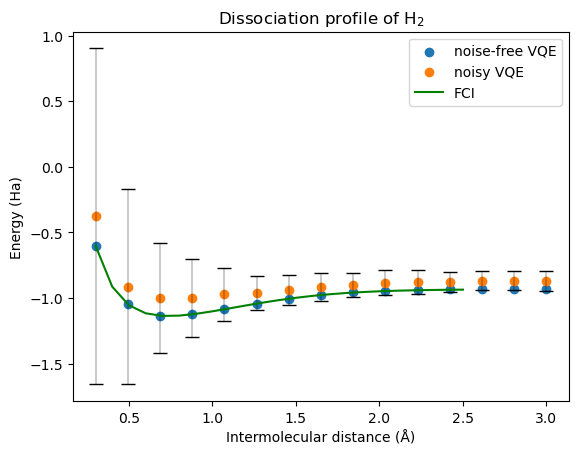

In [132]:
from matplotlib import pyplot as plt

plt.scatter(H_radii/bohr_to_ång, ideal_H2.return_last_energies(), label='noise-free VQE')
plt.scatter(H_radii/bohr_to_ång, noisy_H2.return_last_energies(), label='noisy VQE')
plt.errorbar(H_radii/bohr_to_ång, noisy_H2.return_last_energies(), yerr=noisy_H2.return_last_vars(), 
             linestyle='none', capsize=5,color='black', elinewidth=0.3)
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 1.))]
Rs = np.linspace(0.3,2.5,100)
Rs, fci_energies = FCI(geometry, Rs)
plt.plot(Rs, fci_energies, label='FCI', color='green')
plt.xlabel('Intermolecular distance (Å)')
plt.ylabel('Energy (Ha)')
plt.title('Dissociation profile of H$_2$')

plt.legend()
plt.show()

                   Figure 1. Dissocation profiles of the hydrogen molecule
                                 with two active electrons.
                   

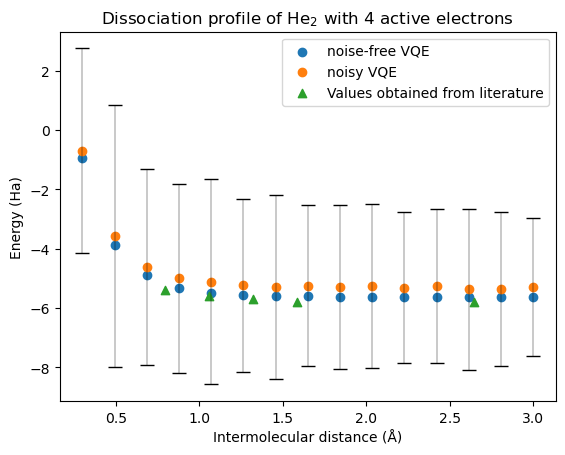

In [155]:
plt.scatter(He_radii/bohr_to_ång, ideal_He2.return_last_energies(), label='noise-free VQE')
plt.scatter(He_radii/bohr_to_ång, noisy_He2.return_last_energies(), label='noisy VQE')
plt.errorbar(He_radii/bohr_to_ång, noisy_He2.return_last_energies(), yerr=noisy_He2.return_last_vars(), 
             linestyle='none', capsize=5,color='black', elinewidth=0.3)
gt_x = np.array([1.5, 2, 2.5, 3, 5])/bohr_to_ång
gt_y = [-5.4, -5.6, -5.7, -5.8, -5.8]
plt.scatter(gt_x, gt_y, label='Values obtained from literature', marker='^')
plt.title('Dissociation profile of He$_2$ with 4 active electrons')
plt.xlabel('Intermolecular distance (Å)')
plt.ylabel('Energy (Ha)')
plt.legend()
plt.show()

              Figure 2. Dissocation profiles of the helium molecule
                            with 4 active electrons.
                   

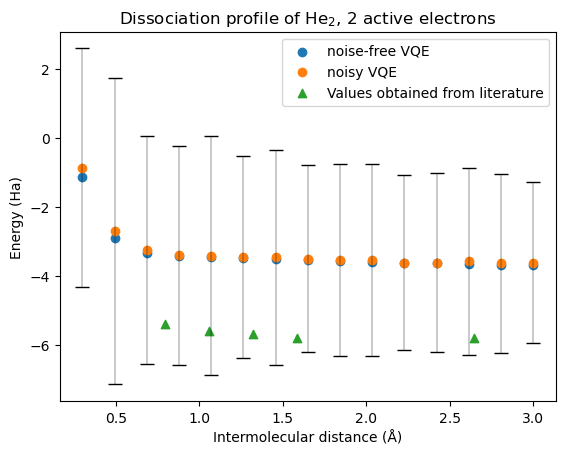

In [152]:
plt.scatter(He_radii/bohr_to_ång, ideal_He2_2e.return_last_energies(), label='noise-free VQE')
plt.scatter(He_radii/bohr_to_ång, noisy_He2_2e.return_last_energies(), label='noisy VQE')
plt.errorbar(He_radii/bohr_to_ång, noisy_He2_2e.return_last_energies(), yerr=noisy_He2.return_last_vars(), 
             linestyle='none', capsize=5,color='black', elinewidth=0.3)
gt_x = np.array([1.5, 2, 2.5, 3, 5])/bohr_to_ång
gt_y = [-5.4, -5.6, -5.7, -5.8, -5.8]
plt.scatter(gt_x, gt_y, label='Values obtained from literature', marker='^')
plt.title('Dissociation profile of He$_2$, 2 active electrons')
plt.xlabel('Intermolecular distance (Å)')
plt.ylabel('Energy (Ha)')
plt.legend()
plt.show()

             Figure 3. Dissociation profile of the helium molecule with 
                              two active electrons.

## Conclusion

The ground state energy approximations of the VQE algorithm with and without noise for the H$_2$ and H$_2$ molecules were obtained and compared against the ground truth and computed literature values. The results for the ideal VQE were accurate and relatively good for the small molecules inspected in this project. The experiment was successful in its goal to showcase the effect of realistic noise without the use of error-correction or error-mitigation methods. Similarly, the hypotheses were matched, as the He$_2$ VQEs performed significantly worse with the smaller active electron count of 2. These results answered the research question posed in the beginning.

The ```VQEs``` class can be used for easily storing and returning dissociation profiles of different molecules, and could be extended to build the circuit object based on given arguments for the ansatz and so on. One would find even more utility with this class with larger-scale tests.

Further testing could include trying more and bigger molecules, different ansatze, such as the UCCSD ansatz [13], different learning rates, different optimizers, and including metrics for measuring the accuracy rigorously for brevity. Additionally, to make things more realistic for the noisy simulator, shot-noise, error-correction and error-mitigation techniques such as zero-noise extrapolation [13] could be explored.

## References

[1] I. N. Levine, Quantum chemistry. Boston: Pearson, Cop. [I.E, 2014.

[2] A. Peruzzo et al., “A variational eigenvalue solver on a photonic quantum processor,” Nature Communications, vol. 5, no. 1, Jul. 2014, doi: https://doi.org/10.1038/ncomms5213.

‌[3] Aspuru-Guzik, A., Dutoi, A. D., Love, P. J., & Head-Gordon, M. (2005). Simulated Quantum Computation of Molecular Energies. Science, 309(5741), 1704-1707.

[4] K. Bharti et al., “Noisy intermediate-scale quantum (NISQ) algorithms,” Reviews of Modern Physics, vol. 94, no. 1, p. 015004, Feb. 2022, doi: https://doi.org/10.1103/RevModPhys.94.015004.

[5] J. Tilly et al., ‘The variational quantum eigensolver: a review of methods and best practices’, Physics Reports, vol. 986, pp. 1–128, 2022.

[6] C. G. Gray, G. Karl, and V. A. Novikov, “The Four Variational Principles of Mechanics,” Annals of Physics, vol. 251, no. 1, pp. 1–25, Oct. 1996, doi: https://doi.org/10.1006/aphy.1996.0104.

[7] M. Born, ‘Born-oppenheimer approximation’, Ann. Phys, vol. 84, pp. 457–484, 1927.

[8] P. Jordan and E. Wigner, Über das Paulische Äquivalenzverbot, Zeitschrift für Physik 47, No. 9. (1928), pp. 631–651, doi:10.1007/BF01331938

[9] S. J. Devitt, W. J. Munro, and K. Nemoto, “Quantum error correction for beginners,” Reports on Progress in Physics, vol. 76, no. 7, p. 076001, Jun. 2013, doi: https://doi.org/10.1088/0034-4885/76/7/076001.

[10] P. J. Knowles and N. C. Handy, “Unlimited full configuration interaction calculations,” The Journal of Chemical Physics, vol. 91, no. 4, pp. 2396–2398, Aug. 1989, doi: https://doi.org/10.1063/1.456997.

[11] “IBM Quantum System Information,” IBM Quantum. https://quantum.ibm.com/services/resources?services=systems (accessed May 17, 2024).

[12] D. Kunik and U. Kaldor, “Ground State of He2 by the Spin‐Optimized Method,” The Journal of Chemical Physics, vol. 56, no. 4, pp. 1741–1745, Feb. 1972, doi: https://doi.org/10.1063/1.1677434.
‌
‌[13] J. Romero, R. Babbush, J. R. McClean, C. Hempel, P. J. Love, and A. Aspuru-Guzik, “Strategies for quantum computing molecular energies using the unitary coupled cluster ansatz,” Quantum Science and Technology, vol. 4, no. 1, p. 014008, Oct. 2018, doi: https://doi.org/10.1088/2058-9565/aad3e4.

[13] A. He, B. Nachman, W. A. de Jong, and C. W. Bauer, “Zero-noise extrapolation for quantum-gate error mitigation with identity insertions,” Physical Review A, vol. 102, no. 1, Jul. 2020, doi: https://doi.org/10.1103/physreva.102.012426.